# GreenBuildings 1: Exploratory Analysis & Outlier Removal
------


## Introduction 
-------------
	
I started this project a while back with a goal of taking the 2016 NYC Benchmarking Law building energy usage data and do something interesting with it. I originally attmpted to clean and analyze this data set to try to find ways to reduce builings' energy usage and subsequently their green house gas emissions. After a few iterations I thought it might be interesting to see if we could additionally predict the emission of green house gases from buildings by looking at their age, energy and water consumption as well as other energy consumption metrics.  In this first blogpost I will cover how to perform,

- Exploratory data analysis
- Identify and remove outliers

Since I will completing this project over multiple days and using [Google Cloud](https://cloud.google.com/), I will go over the basics of using [BigQuery](https://cloud.google.com/bigquery) for data storage so as to not have to start all over again each time I work on it.  At the end of this blogpost I will summarize the findings, and give some specific recommendations to reduce mulitfamily and office building energy usage. The source code for this project can be found <a href="https://github.com/mdh266/NYCBuildingEnergyUse">here</a>.

----------
### Data 
----------
The NYC Benchmarking Law requires owners of large buildings to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. This data gives building owners information about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.

Benchmarking data is also disclosed publicly and can be found <a href="http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml">here</a>.  I analyzed the 2016 data and my summary of the findings and recommendations for reducing energy consumption in New York City buildings are discussed in the conclusions section.

The data comes from the year 2016 and is quite messy and a lot of cleaning is necessary to do analysis on it. The cleaning process was made more difficult because the data was stored as strings with multiple non-numeric values which made converting the data to its proper type a more involved process.  One thing to keep in mind through out this post is that this is **self-reported data**, meaning our data is mostly biased, containinig outliers. Therefore, I will go over a few techniques for removing outliers in post.

--------------------------
## Exploratory Data Analysis
-------------------------
Since the cleaning was more tedious I created external functions do handle this processes.  In addition, I also a created functions to handle transforming and plotting the data.  I kept these functions in seperate files <code>Cleaning_Functions.py</code> and <code>Plotting_Functions.py</code> respecively so as to not clutter the post.  We import these functions along with other basic libraries (<a href="http://pandas.pydata.org/">Pandas</a>, <a href="http://matplotlib.org/">Matplotlib</a> and <a href="http://seaborn.pydata.org/">Seaborn</a>) as well as read in the data file below:

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from Cleaning_Functions import (initial_clean, 
                                convert_GeoPandas_to_Bokeh_format,
                                group_property_types)
                                
from Plotting_Functions import (plot_years_built, 
                                make_interactive_choropleth_map)

Here is we specifify a few datatypes as integers while reading in the Excel using the [read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) function from Pandas

In [16]:
df_2016 = pd.read_excel("data/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
                       converters={'Street Number':int, 
                                   'Zip Code':int,
                                   'Year Build':int,
                                   'ENERGY STAR Score':int})

There are about 13,233 buildings with different types of energy usage, emissions and other information.  I'll drop a bunch of these features and only keep the following,

- Reported NYC Building Identification Numbers : [BINs]
- NYC Borough, Block and Lot : [BBL]
- Street Number : [Street_Number]
- Street Name : [Street_Name]
- Zip Code : [Zip_Code]
- Borough : [Borough]
- Year Built : [Year_Built]
- DOF Benchmarking Status :[Benchmarking_Status]
- Site EUI (kBtu/ft$^{2}$) : [Site_Eui]
- Natural Gas Use [N(kBtu) : [Nat_Gas]
- Electricity Use (kBtu):  [Elec_Use]
- Total GHG Emissions (Metric Tons CO2e) : [GHG]
- ENERGY STAR Score : [Energy_Star]
- Water Use (All Water Sources) (kgal) : [Water_Use]

The terms in the square brackets are the column names used in the dataframe. In addition, we must do some basic feature engineering.  The reported data gives us the metrics (`NAT_Gas`, `Elec_Use`, `GHG`, `Water_Use`) in terms of total volume. Using these metrics in comparing buildings of different sizes is not a fair comparison.  In order to compare them fairly we must standardize these metrics by dividing by the square footage of the buildings giving us each metrics' intensity. We therefore have the following features,


- Nautral Gas Use Intensity (kBtu/ft$^{2}$) : [NGI]
- Electricty Use Intensity (kBtu/ft$^{2}$) : [EI]
- Water Use Intensity (kga/ft$^2$) : [WI]
- Total GHG Emissions Intensity (Metric Tons CO2e / ft$^2$) : [GHGI]
- Occupancy Per Square Foot (People / ft$^2$) : [OPSQFT]
- Age (years)


I wrote a basic function called <code>initial_clean()</code>. to clean the data create the additional features. We call it on our dataset and then get some basic statistics about the data:

In [17]:
df_2016_2 = initial_clean(df_2016)
temp_cols_to_drop = ['BBL','Street_Number','Zip_Code','Occupancy']

df_2016_2.drop(temp_cols_to_drop, axis=1)\
         .describe()

,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT,Age
count,9535.000000,11439.000000,1.008700e+04,1.142500e+04,1.147800e+04,7.265000e+03,9870.000000,11206.000000,7261.000000,11258.000000,11311.000000,11531.000000
mean,57.735711,525.733377,2.520461e+07,8.201496e+06,6.952577e+03,2.579751e+04,137.705639,54.266179,0.161268,0.031272,0.001065,67.857168
std,30.143817,10120.105154,1.194068e+09,1.214643e+08,1.692231e+05,5.860239e+05,7512.527146,1210.530111,2.053453,0.571378,0.000536,30.263637
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000
25%,34.000000,65.300000,8.915501e+05,1.045702e+06,3.420250e+02,2.661700e+03,7.324853,13.682696,0.028523,0.004308,0.000629,50.000000
50%,63.000000,82.400000,4.067600e+06,1.885996e+06,5.198000e+02,4.745600e+03,46.268145,18.482229,0.046098,0.005455,0.001075,76.000000
75%,83.000000,103.000000,6.919267e+06,4.513704e+06,9.394500e+02,8.057900e+03,68.036285,30.716894,0.073287,0.007003,0.001525,90.000000
max,100.000000,801504.700000,1.101676e+11,1.047620e+10,1.501468e+07,4.385740e+07,737791.764249,84461.681703,98.340480,39.190314,0.001999,417.000000


The above table is only a summary of the numrical data in the dataframe. Just looking at the <code>count</code> column we can immediately see that there are a lot of missing valus in this data. This tells me that this data will be rather messy with many columns having NaNs or missing values.

*It also looks like there is a lot of variation within this dataset.  Just looking at the <code>Site_EUI</code> statistic, the 75th percentile is is 103 (kBtu/ft²), but the max is 801,504.7 (kBtu/ft²).  This probably due to the number of different types of buildings in the city, as well as the fact that contains outliers.*


The next thing I would like to see is how many of the buildings in NYC are passing the Benchmarking Submission Status:

Text(0, 0.5, 'count')

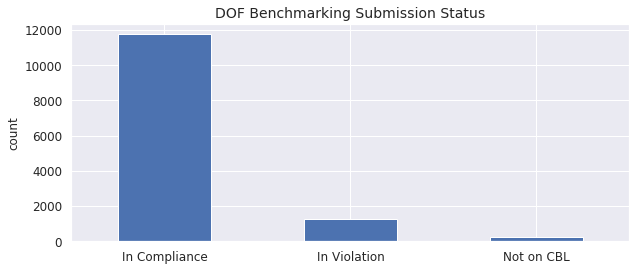

In [18]:
plt.figure(figsize=(10,4))
df_2016_2['Benchmarking_Status'].value_counts()\
                                .plot(kind='bar',
                                      fontsize=12,
                                      rot=0)
    
plt.title('DOF Benchmarking Submission Status',fontsize=14)
plt.ylabel('count',fontsize=12)

Most buildings are in compliance with the Department of Finance Benchmarking standards. Let's take a look at the violators:

In [19]:
Violators = df_2016_2[df_2016_2.Benchmarking_Status == 'In Violation']
Violators.head()

,BBL,BINs,Street_Number,Street_Name,Zip_Code,Borough,Benchmarking_Status,Property_Type,Year_Built,Occupancy,...,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT,Age
11978,2.051410e+09,NaN,300,BAYCHESTER AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11979,3.088400e+09,NaN,3939,SHORE PARKWAY,11235,Brooklyn,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11980,3.088420e+09,NaN,2824,PLUMB 3 STREET,11235,Brooklyn,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11981,2.051411e+09,NaN,2100,BARTOW AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11982,2.051410e+09,NaN,312,BAYCHESTER AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There's not much we can learn from this, if we can look to see if certain zip codes have more buildings in violation.  First thing we do is group by the zip codes and count them to get the number of violations per zip code:

In [20]:
zips_df = Violators.groupby('Zip_Code')['Zip_Code'].size()\
                   .reset_index(name='counts')

Now we want to visualize the the number of violators per zip code. To make things interesting we will create an interactive choropleth map using the <a href="https://bokeh.pydata.org/en/latest/">Bokeh</a> Library.  Bokeh is a great vizualization tool that I have used in the <a href="http://michael-harmon.com/blog/IntroToBokeh.html">past</a>.  We get the shapes for New York City zip codes as a geojson file from this <a href="http://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas">site</a>.  The geojson file can be read into a dataframe using <a href="http://geopandas.org/">GeoPandas</a>.

In [21]:
import geopandas as gpd
gdf = gpd.read_file("data/nyc-zip-code-tabulation-areas-polygons.geojson")

# GeoPandas doesn't allow users to convert the datatype while reading it in so we do it here
gdf["postalCode"] = gdf["postalCode"].astype(int)

We can see the basic contents of the GeoPandas dataframe:

In [22]:
gdf.head(2)

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
0,1,11372,Jackson Heights,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,POLYGON ((-73.86942457284177 40.74915687096788...
1,2,11004,Glen Oaks,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,POLYGON ((-73.71132911125308 40.74947450816085...


I noticed only a few of the zipcodes had actual names, so I wrote a script (`getNeighborhoodNames.py`) to scrape <a href="https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm">this website</a> to obtain each neighborhood's name.  I pickled the results so we could use them here:

In [23]:
zip_names = pd.read_pickle("data/neighborhoods.pkl")

We can attach them to our GeoPandas dataframe by joining them (on zip code),

In [24]:
gdf = gdf.drop(['PO_NAME'],axis=1)\
         .merge(zip_names, on="postalCode",how="left")\
         .fillna("")

Next, we'll left join our count of violators-per-zipcode <code>zips_df</code> to above dataframe and fill in the zip codes that do not have violations with zeros:

In [25]:
gdf= gdf.merge(zips_df, how="left", left_on="postalCode", right_on="Zip_Code")\
         .drop(["OBJECTID","Zip_Code"], axis=1)\
         .fillna(0)

gdf.head(2)   

,postalCode,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,PO_NAME,counts
0,11372,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,POLYGON ((-73.86942457284177 40.74915687096788...,West Queens,5.0
1,11004,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,POLYGON ((-73.71132911125308 40.74947450816085...,Southeast Queens,0.0


Now before we can use Bokeh to visualize our data we must first convert the GeoPandas dataframe to a format that Bokeh can work with. Since I already covered this in a previous blog <a href="http://michael-harmon.com/blog/IntroToBokeh.html">post</a> I won't go over the details, but here I used a slightly modified version of the function from that post:

In [26]:
bokeh_source = convert_GeoPandas_to_Bokeh_format(gdf)

Next we set bokeh `io` module to be in the notebook and use the function I wrote <code>make_interactive_choropleth_map</code> to create the in-notebook zipcode choropleth map:

In [27]:
from bokeh.io import output_notebook, show
output_notebook()

# We get the min and max of the number of violations to give the cloropleth a scale.
max_num_violations = zips_df['counts'].max()
min_num_violations = zips_df['counts'].min()

fig = make_interactive_choropleth_map(bokeh_source,
                                      count_var = "Number Of Violations",
                                      min_ct    = min_num_violations,
                                      max_ct    = max_num_violations)
show(fig)

Loading BokehJS ...

You can hover your mouse over the each of the zipcode and the map will display the neighborhood name and number of violations. From this we can see that Chelsea, Downtown Brooklyn and Long Island City neighborhood have the highes number of violations.

The fact that different neighborhoods have different numbers of violating buildings gives us the suspicion that **the neighborhood may be correlated with the buildings energy usage**, this could be because of building owners that are in voliation owning multiple buildings on a single lot or neighrborhood.

Now let's move back to analyzing the buidlings that are not in violation.  First let's see the distributution of all buildings that are in different ranges of the <code>Energy Star</code> ratings:

Text(0.5, 0, 'ENERGY STAR Score')

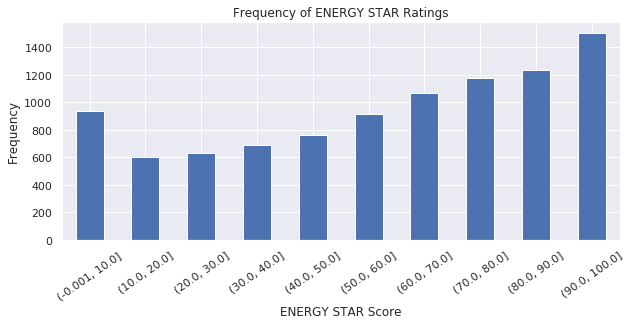

In [28]:
bins = [0,10,20,30,40,50,60,70,80,90,100]

df_2016_2['Energy_Star'].value_counts(bins=bins)\
                        .sort_index()\
                        .plot(kind    = 'bar',
                              rot     = 35,
                              figsize = (10,4),
                              title   = 'Frequency of ENERGY STAR Ratings')
plt.ylabel('Frequency')
plt.xlabel('ENERGY STAR Score')

We can see that the majority are within the 50-100 range, but a almost 1000 buildings have scores inbetween 0 and 10. Let's take a look at the distribution of building types.  We will just take the top 10 most common building types for now..

Text(0, 0.5, 'Frequency')

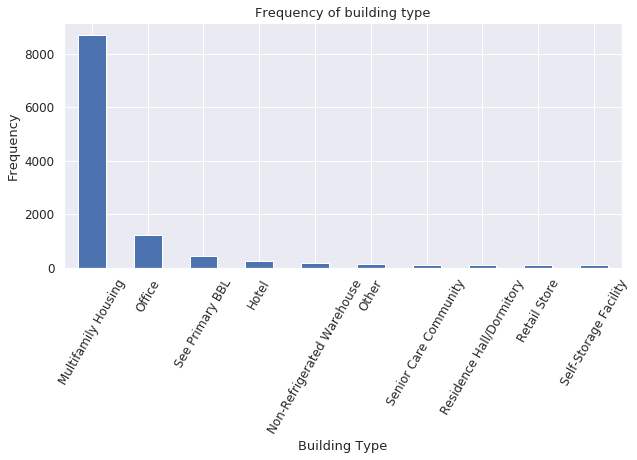

In [29]:
df_2016_2['Property_Type'].value_counts()\
                          .head(10)\
                          .plot(kind     = 'bar',
                                figsize  = (10,4.5),
                                fontsize = 12,
                                rot      = 60)
        
plt.title('Frequency of building type', fontsize=13)
plt.xlabel('Building Type', fontsize=13)
plt.ylabel('Frequency', fontsize=13)

The most common buildings in NYC are multifamily housing, then offices, other, hotels and somewhat suprisingly non-refrigerated warehouse space.  I would have thought that there would be more schools and retail spaces than warehouses or dormitorites in New York City, but I don't know what the <code>Primary BBL</code> listing is.


Let's look at the Energy Star ratings of buildings across different building types, but first how many different building types are there?  We can find this out,

In [30]:
print("Number of building types are: {}".format(len(df_2016_2['Property_Type'].unique())))

Number of building types are: 54


This is too many building types to visualize the Energy Star Score (<code>Energy_Star</code>) of each, we'll just look at just 5 building types, lumping the 54 into the categories into either:
- Residential
- Office
- Retail
- Storage
- Other

I built a function to group the buildings into the 5 types above called <code>clean_property_type(...)</code> and we use it below to transform the Pandas Series:

In [31]:
Property_Type = df_2016_2.copy()
Property_Type['Property_Type'] = Property_Type['Property_Type'].apply(group_property_types)

Now we can look at the  <code>Energy_Star</code> (score) of each of the grouped buildings types:

Text(0, 0.5, 'Frequency')

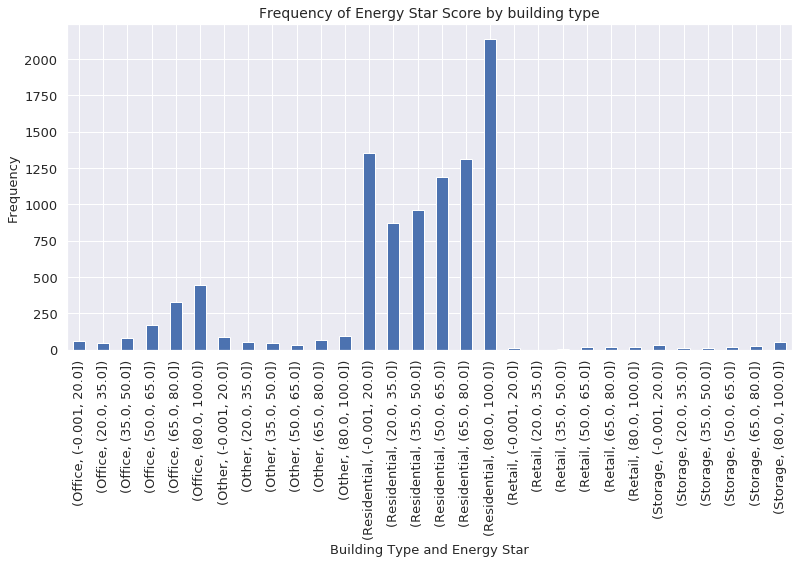

In [32]:
bins2 = [0,20,35,50,65,80,100]

Energy_Star_Scores = Property_Type.groupby(['Property_Type'])['Energy_Star']

Energy_Star_Scores.value_counts(bins=bins2)\
                  .sort_index()\
                  .plot(kind='bar',
                        figsize=(13,6),
                        fontsize=13)

plt.title('Frequency of Energy Star Score by building type',fontsize=14)
plt.xlabel('Building Type and Energy Star', fontsize=13)
plt.ylabel('Frequency', fontsize=13)

Overall it looks like residential buildings have a lot more proportion of low Energy Star Scoring buildings when compared to office buildings. This is probably because there are much more older residential buildings than office spaces in New York City. We'll look at the distribution of the years in which builings of just properties of type: 'Multifamily Housing' and 'Office' were built:

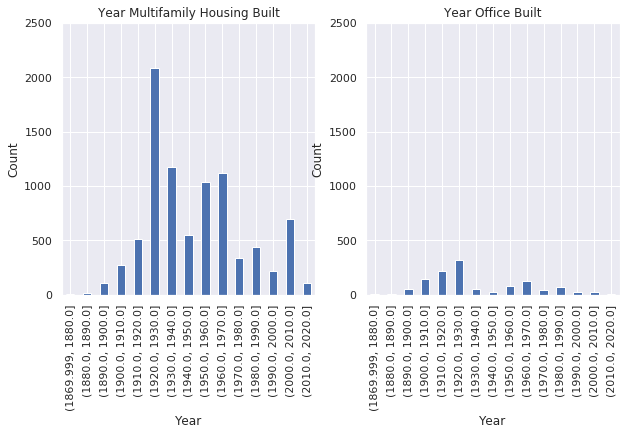

In [33]:
plot_years_built(df_2016_2)

It seems like it's the opposite of what I thought, but the number of residential buildings is much higher and the majority were built right before and right after World War 2, as well as in the 2000s.  The same is true about offices, however, without the uptick in the early 2000s.

-------------------------------------
## Connecting To BigQuery
--------------------------------------


Let's focus on the multifamily housing off buildings to see what we can find out about them since these make up the majority of buildings and may offer the best return on investment in terms of improving energy efficiency. Let's create our dataset focusing on the fields:

    - Energy Star 
    - Site Energy Usage Intensity (Site_EUI)
    - Natural Gas Intensity (NGI)
    - Eletricity Intensity (EI)
    - Water Intensity (WI)
    - Green House Gas Intensity (GHGI)
    - Occupancy Per Sq Ft (OPSFT)
    - Age 
    - Residential (1 or 0 if true or false)
    
We choose these fields as they should be independent of size of the building and therefore comparable across buildings.

In [34]:
Buildings = df_2016_2[df_2016_2['Property_Type'].isin(['Office','Multifamily Housing'])]

Buildings = Buildings.merge(pd.get_dummies(Buildings["Property_Type"])[["Multifamily Housing"]]
                              .rename(columns={"Multifamily Housing":}),
                            left_index=True,
                            right_index=True)
                            
columns   = ["Energy_Star", "Site_EUI", "NGI", "EI", "WI", 
             "GHGI", "OPSFT", "Age", "Residential"]

Buildings = Buildings[columns]

Now since I will be working on this project over a few days I write this data to table so I won't have to constantly load and clean it again and again.  Since I'm using the [Google Cloud Platform](https://cloud.google.com/), I'll using [BigQuery](https://cloud.google.com/bigquery) for storing my data.  This requires that I have credentials.  I used the [google-auth-oauthlib](https://pypi.org/project/google-auth-oauthlib/) package and followed the instructions [here](https://cloud.google.com/bigquery/docs/authentication/end-user-installed) to create a credentials json file:

In [7]:
from google.oauth2 import service_account

credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

Next I installed [pandas-gbq](https://pandas-gbq.readthedocs.io/en/latest/) for connecting Pandas and BigQuery and set my credentials and project:

In [9]:
import pandas_gbq 

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project     = credentials.project_id

Then I created a table `raw_data` in the database `db_gb` using the [to_gbq](https://pandas-gbq.readthedocs.io/en/latest/writing.html) function:

In [46]:
pandas_gbq.to_gbq(Buildings, 
                  "db_gb.raw_data")

And were done! We can query the data from the BigQuery UI as shown below:

![bigquery](images/bigquery.png)

Let's move onto removing outliers.

Firs thing we need to do is to get the data from BigQuery as a Pandas dataframe.  We use the [read_gbq](https://pandas-gbq.readthedocs.io/en/latest/reading.html) function from pandas_gbq:

In [10]:
X = pandas_gbq.read_gbq("""SELECT 
                               Energy_Star,
                               Site_EUI,
                               NGI,
                               EI,
                               WI,
                               GHGI,
                               OPSFT,
                               Age,
                               Residential,
                            FROM 
                                db_gb.raw_data 
                            """)

Downloading: 100%|██████████| 9932/9932 [00:01<00:00, 9532.86rows/s]


We can then look at the distribution of values in the dataframe:

In [38]:
X.describe()

,Energy_Star,Site_EUI,NGI,EI,WI,GHGI,OPSFT,Age,Residential
count,8617.000000,9879.000000,8527.000000,9656.000000,6281.000000,9686.000000,9720.000000,9932.000000,9932.000000
mean,58.403505,495.677558,150.094551,41.164075,0.099990,0.028340,0.001078,68.944724,0.875856
std,29.968956,10494.559237,8081.609124,807.887239,0.852744,0.582040,0.000535,29.120410,0.329763
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000
25%,35.000000,67.100000,7.182433,13.636592,0.031498,0.004417,0.000641,53.000000,1.000000
50%,63.000000,82.400000,48.764998,17.831709,0.047561,0.005447,0.001095,77.000000,1.000000
75%,84.000000,101.200000,68.696570,26.824484,0.073500,0.006836,0.001536,90.000000,1.000000
max,100.000000,801504.700000,737791.764249,65067.140501,52.143200,39.190314,0.001999,417.000000,1.000000


We can see again, large variations in the energy data, with most of it being between 0 and some fixed number with atleast one outlier.  For example, the minimum age of a building is -2, which is absurd!  We can also see from the varying "count" values that there are a significant number of missing values.  Let's find out just how many buildings have atleast one missing value:

In [39]:
X_clean = X.dropna()

print("Total Buildings: {}".format(X.shape[0]))
print("Total Buildings without any missing data: {}".format(X_clean.shape[0]))

Total Buildings: 9932
Total Buildings without any missing data: 4880


About half of the buildings have missing data, that's significant. We'll first deal with removing outliers and then after that work on imputing missing values.

Let's plot the correlation matrix to see how correlated are features are on the all the buildings.  Note that we first have to normalize the data.

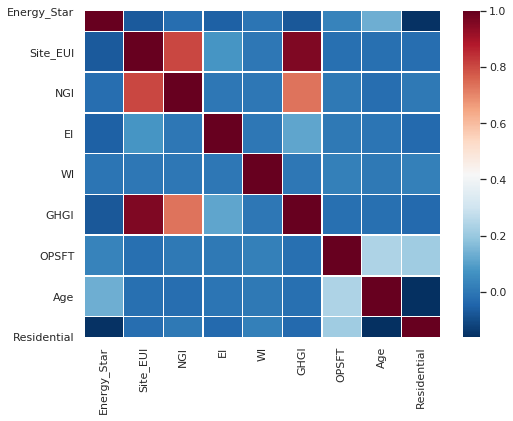

In [40]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
Xs      = scaler1.fit_transform(X)
xs_df   = pd.DataFrame(Xs, columns=X.columns)

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(xs_df.corr(),
            linewidths=.5,
            cmap="RdBu_r")

We can see that,

- **Natural gas usage is fairly strongly correlated to green house emission rates which makes sense.**


- **Energy usage intensity is strongly correlated with natural gas intensity and greenhouse gas emissions. These make sense, since gas is a primary form of heating.**

What doesn't make sense to me is that *the energy star score is weakly correlated to any of the measures of energy, water or emissions*.  This is strange to me because a higher energy star score is supposed to reflect more efficient use of energy and water.  Furthermore, the energy star score goes up (slightly) as the age increases which doesn't make sense as the I would expect older homes to be less energy efficient.

We can see how the results change when we only use building data that does not have missing values:

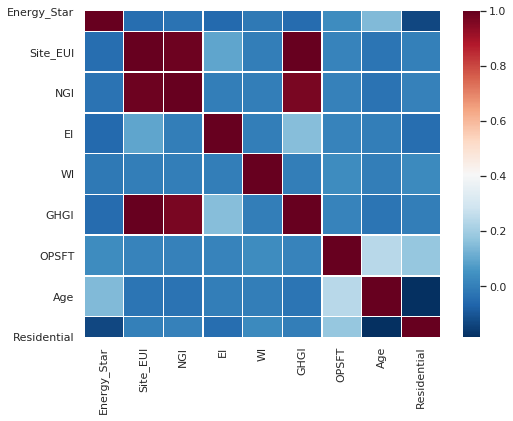

In [34]:
Xs_clean_df = pd.DataFrame(StandardScaler().fit_transform(X_clean), 
                           columns=X_clean.columns)

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(Xs_clean_df.corr(),
            linewidths=.5,
            cmap="RdBu_r")

The previously mentioned correlations are now stronger, but there is still too weak a correlation between energy star score and energy or water usage for my liking.  We'll have to dig deeper into the data to see if there are outliers that are affecting our correlation matrix.

## Removing Outliers

In this section we'll be looking at box plots and scatter plots of various features against the  to try to identify outliers in the data. We'll first look at box plots, separating out `Age` and energy metrics as they are very different scales. 

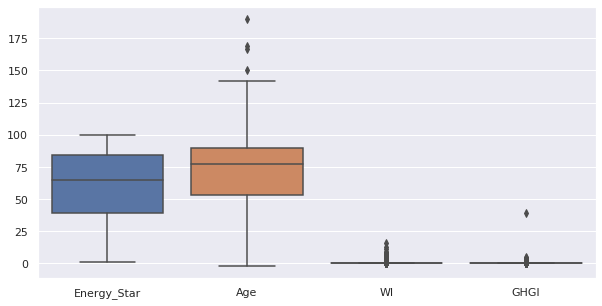

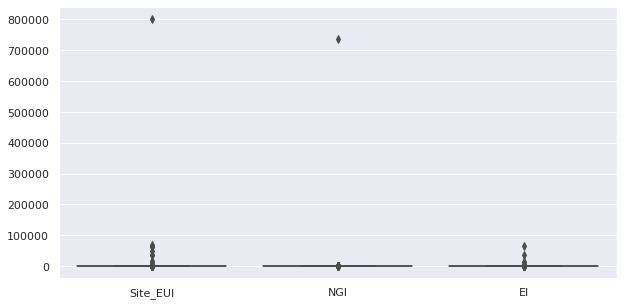

In [41]:
plt.figure(figsize=(10,5))
sns.boxplot(data=X_clean[["Energy_Star","Age","WI","GHGI",]])

plt.figure(figsize=(10,5))
sns.boxplot(data=X_clean[["Site_EUI","NGI","EI"]])

We can see that there are a TON of outliers in all of the fields except `Energy_Star` and `Age`.  various features against the Site_EUI to try to identify outliers in the data. For the purposes of this removing outliers let's focus on just `NGI`,`EI`,`WI`,`GHGI` and `Site_EUI` as we expect these correalted.  Let's look at the scatter plot of `NGI`,`EI`,`WI`,`GHGI` against `Site_EUI`, as we should expect the former to be directly related to the later.

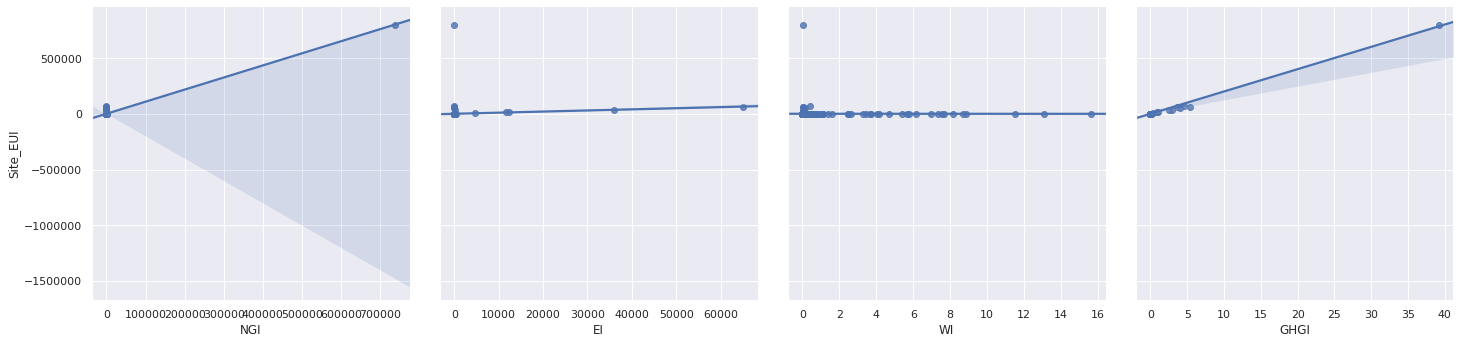

In [42]:
sns.pairplot(X_clean, 
             x_vars=['NGI','EI','WI','GHGI'], 
             y_vars='Site_EUI', 
             kind = 'reg',
             size=5, 
             dropna=True)

Definitely a lot of outliers! We'll go through each of the individual scatter plots to find outliers each of the fields.

Let's first look at the scatter plot of natural gas intensity and energy usage intensity to see if we can observe outliers that may be affecting our correlation matrix.  *The reason we are doing so is that we suspect energy usage intensity should be highly correlated to natural gas intensity since natural gas is used for cooking and heating.*

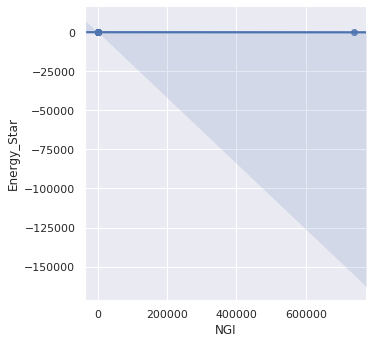

In [43]:
sns.pairplot(X_clean, 
             x_vars='NGI',
             y_vars='Energy_Star',
             kind='reg',
             size=5,
             dropna=True)

We can see that are some signficant outliers in our data.  Experimenting with different values i was able to remove them and a clearer relationship between the natural gas usage and EUI:

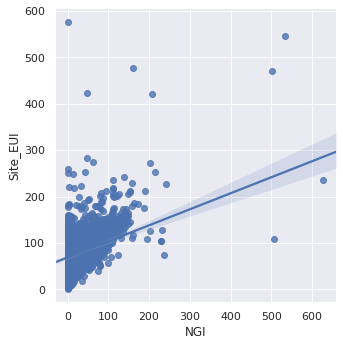

In [44]:
X_clean1 = X_clean.query("NGI < 1e3 & Site_EUI < 1e3")

sns.pairplot(X_clean1, 
             x_vars='NGI',
             y_vars='Site_EUI',
             kind='reg',
             size=5,
             dropna=True)

We can see that **buildings that have higher natural gas usage per sqft have a higher energy intensity and this makes sense!** We could repeat the same procedure for electricity usage intensity and EUI since again, but removing the outliers in `NGI` actually removed most of the outliers:

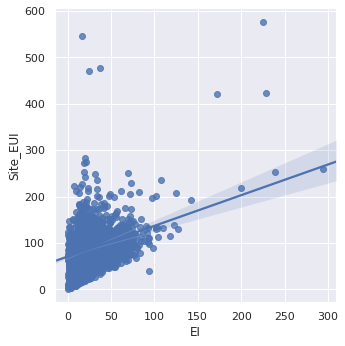

In [45]:
sns.pairplot(X_clean1, 
             x_vars='EI', 
             y_vars='Site_EUI', 
             kind='reg', 
             size=5,
             dropna=True)

The relationship is less obvious, but we can see that **buildings with higher electricity per square foot have a higher energy usage intensity.** 

Now we do the same for water usage intensity and EUI.  While it might not seem water and energy usage could be correlated with energy usage intensity, often water is used for heating and cooling. 

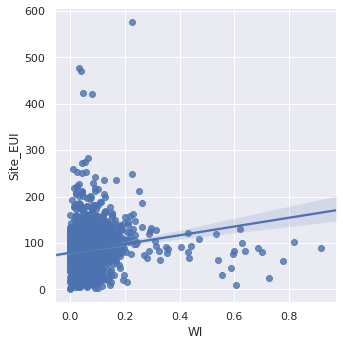

In [46]:
X_clean2 = X_clean1.query("WI < 1")

sns.pairplot(X_clean2,
             x_vars='WI', 
             y_vars='Site_EUI',
             kind='reg',
             size=5, 
             dropna=True)

Interestingly, here we see a slighly weaker positive correlation, meaning **buildings which use more water per square foot only have marginarly higher energy usage intensity.** 

Lastly we repleat the procedure for green house has emission intensity, since you would think that if a building is more energy intensive it has a much larger carbon foot print.


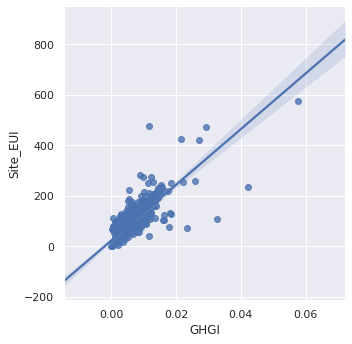

In [47]:
sns.pairplot(X_clean2,
             x_vars='GHGI', 
             y_vars='Site_EUI',
             kind='reg',
             size=5, 
             dropna=True)

Over all there are not *too many outliers*! I can live with them though. Let's take a look at the box plots again:

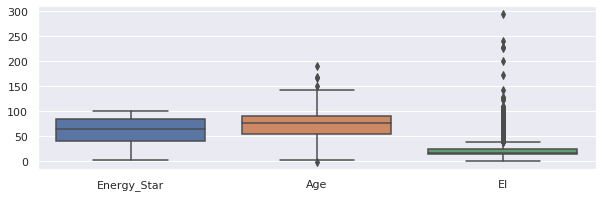

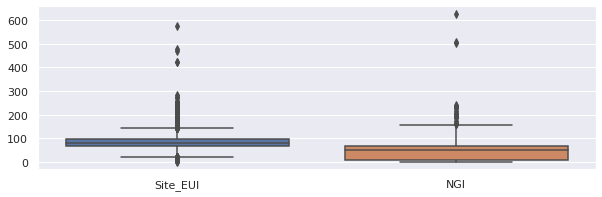

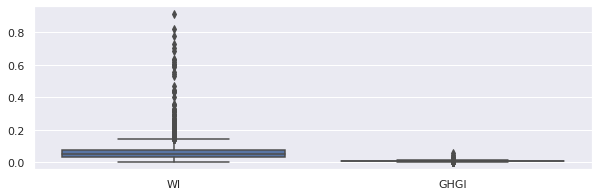

In [48]:
plt.figure(figsize=(10,3))
sns.boxplot(data=X_clean2[["Energy_Star","Age","EI"]])

plt.figure(figsize=(10,3))
sns.boxplot(data=X_clean2[["Site_EUI","NGI"]])

plt.figure(figsize=(10,3))
sns.boxplot(data=X_clean2[["WI","GHGI"]])


Let's look at each of the correlations:

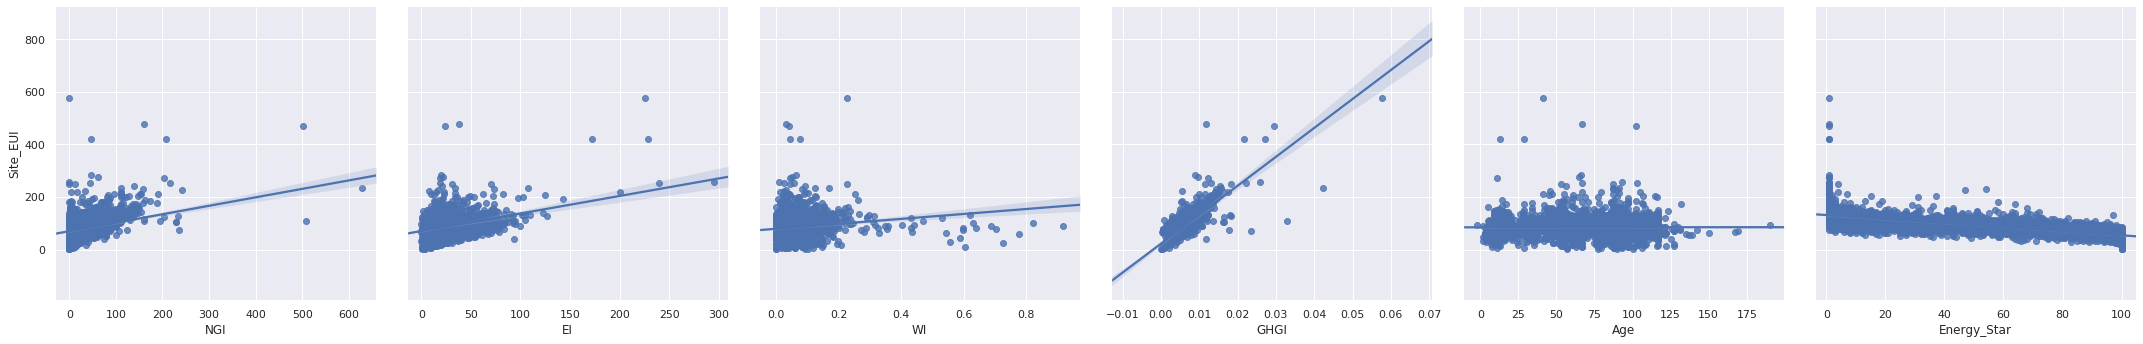

In [49]:
sns.pairplot(X_clean2, 
             x_vars=['NGI','EI','WI','GHGI','Age','Energy_Star'], 
             y_vars=['Site_EUI'], 
             kind = 'reg',
             size=5, 
             dropna=True)

We can see these all make sense as mentioned before. In addition we see two new scatter plots, `Site_EUI` vs `Age` which appears to have no correlation.  This would seem counter-intuitive but most of the buildings in NYC are quite old.  The last correaltion `Site_EUI` vs `Energy_Star` which is somewhat nonlinear, but shows that as Enegery Star increases the site energy usage goes down.  This makes sense!

It look's like EUI is very positively correlated to the green house gas emission intensity and natural gas usage intensity.  The relationship between EUI is slightly less strongly correlated to electricity usage intensity and even less so with water usage intensity.  

We can also see from the plot below that the site **EUI was not very correlated to the year that the buildings were constructed.**  Most likely this is because so many were built around the same time period.

Now that we have removed some outliers we now have multifamily buildings that have very similar characteristis. We can visualize the correlation matrix to try to gleam some insights into improving these building energy efficiency.

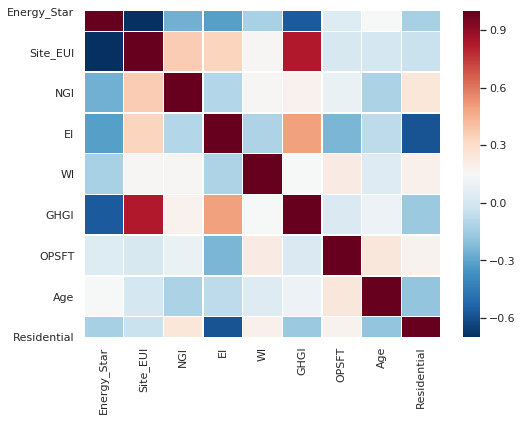

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(X_clean2.corr(),
            linewidths=.5,
            cmap="RdBu_r")

This is a much more belivable correlation matrix than the previous two we looked at!!

*We can see that the Energy Star score is very negatively correlated with enery usage intensity, which make sense as the energy star score is a measure of energy efficiceny of the building.* Furthermore the Energy Star score is negatively correlated with electricity, water, and natural gas usage intensity as well as green house gas emission intensity which makes sense. Additionally, we see that **Energy Star Score is independent of occupancy per square foot which makes sense since it is a fucntion of the building's efficiency and not the people inside of it.**

I'm going to again write the results of outlier removeal to BigQuery so as not to have recompute everything again when I come back to this project.  This time however I will create new table by filterin on the raw data table:

In [51]:
from google.cloud import bigquery
client = bigquery.Client(project     = credentials.project_id,
                         credentials = credentials)

In [52]:
job = client.query("""
CREATE TABLE db_gb.no_outlier_data 
AS 
SELECT
   Energy_Star,
   Site_EUI,
   NGI,
   EI,
   WI,
   GHGI,
   OPSFT,
   Age,
   Residential,
FROM 
    db_gb.raw_data 
WHERE 
    (NGI < 1e3 OR NGI IS NULL)
AND (WI  < 1   OR WI IS NULL)
AND (Site_EUI < 1e3 OR Site_EUI IS NULL)
""")

job.result()

We can see the total number of buidlings we have removed as outliers:

In [74]:
num_rows = client.query("SELECT COUNT(1) FROM db_gb.no_outlier_data")
for row in result.result():
    print("Total Buildings in without ouliers: ", row[0])

Total Buildings in without ouliers:  9834


And compare to the oringal number of buildings:

In [73]:
print("Total Buildings in original data: {}".format(X.shape[0]))

Total Buildings in original data: 9932


We can see that we remvoed 102 buildings or a little more than 1%.  

--------------
## Recommendations & Next Steps
--------------

In this first of a series blog post we analyzed the energy usage of buildings in New York City.  From the final heat map of the correlation matrix we can see that the Energy Star score is negatively correlated with enery usage intensity.  This makes sense as the energy star score is a measure of energy efficiceny of the building. The energy usage intensity has a strong positive correlation to the natural gas usage intensity.  We can see that natural gas usage intensity and electricity usage intensity are uncorrlated.  This implies we could replace one with the other.  Therefore reducing natural gas consumption or replacing it with electricity could be the best answer to reducing energy usage intensity and green house gas emissions.  It should also be noted that year the residence was built did not have any correlation with energy usage intensity. This is probably due to the fact that the majority of residential buildings in New York City were built in a similar time period and before energy efficiency was a priority.


Since natural gas usage intensity is most highly correlated with energy usage intensity reducing it could improve building energy efficiency and reduce green house gas emissions (so long as the buildings' electricity comes from a clean energy source or atleast one with less emissions than natural gas). Some ways to reduce natural gas consumption include:

- Investing in more efficient heating and cooling services or slightly reducing the usage of either heating or cooling during the day when most people are not home. This is especially important in large buildings as HVAC systems have a larger volume of air to heat/cool.


- Another option is to reuse waste heat, such as reusing the vented air from electric clothes dryers, however, filtering and the air will be necessary and could alter the cost effectiveness of this approach.


- Replacing gas powered appliances such as stoves with more efficient electric ones is another option.  However, the source of electric power should also be considered to weigh the overall energy efficiency and enviromental impact.


- Another option is to replace gas powered water heaters by solar powered water heaters. While solar powered water heaters are not as cost effective in moderate climates, the presence of numerous roof top water tanks on New York City buildings may help make this option more financially competitive.  At the very least, it suggests that having roof top water tanks for solar powered water heaters is structurally possible, where as with individual houses this may not be the feasible.


- In addition, buying energy efficient refrigerators and dryers is also important as these are two of the largest energy consumers in ones home.


We saw that there were a lot of fields in the dataset with missing values.  In the next blogpost we will go over the steps to how to impute these missing values.